
<img src="images/green-divider.png" style="width: 100%;" />


# Stack Overflow Annual Developer Survey - 2023  

Stack overflow, the arguably largest platform to discuss and learn coding has been hosting a survey for developers since 2011 now. The survey covers a wide range of topics, including programming languages, frameworks, tools, technologies, job satisfaction, and demographics. It is one of the largest surveys of its kind and provides valuable information about the preferences, trends, and challenges in the software development industry.  

The present data analysis project builds upon the 2023 survey and explores some of its features with emphasis on the data and business analysis field of industry.  
The survey data has already been cleaned by the stack overflow team and is ready to be used for anaylsis. As the survey result csv file is too large for githubs default upload I'll reference it here instead.  
You can find the file at [insights.stackoverflow.com/survey](https://insights.stackoverflow.com/survey)

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display

In [2]:
# load csv file
df = pd.read_csv("stack-overflow-developer-survey-2023/survey_results_public.csv")

# List the column names
display(df.columns)

Index(['ResponseId', 'Q120', 'MainBranch', 'Age', 'Employment', 'RemoteWork',
       'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline',
       'LearnCodeCoursesCert', 'YearsCode', 'YearsCodePro', 'DevType',
       'OrgSize', 'PurchaseInfluence', 'TechList', 'BuyNewTool', 'Country',
       'Currency', 'CompTotal', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith',
       'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith',
       'PlatformWantToWorkWith', 'WebframeHaveWorkedWith',
       'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith',
       'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith',
       'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith',
       'NEWCollabToolsWantToWorkWith', 'OpSysPersonal use',
       'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith',
       'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncHaveWorkedWith',
       'OfficeStackSyncWantToWorkWith', 'AISearchHaveWorkedWith',
       'AISearchWan

## Schema

How do the questions from the survey translate to column names?

In [3]:
# Load the schema file
schema = pd.read_csv("stack-overflow-developer-survey-2023/survey_results_schema.csv")

# To prevent truncation of columns, change the default options
pd.set_option('display.max_colwidth', None)

# To prevent truncation of cells, change the default options 
pd.set_option('display.max_rows', None)

# Truncate introductory text
schema_display = schema[["qname", "question"]][4:]

# Define the styles for the display, Set the alignment for the 'question' column to the left
styles = [
    {'selector': 'td', 'props': [('text-align', 'left')]}
]

# Apply styles to the DataFrame
schema_display.style.set_table_styles(styles)


,qname,question
4,S1,Basic Information The first section will focus on some basic information about who you are. Most questions in this section are required. Required questions are noted with *.
5,MainBranch,"Which of the following options best describes you today? For the purpose of this survey, a developer is ""someone who writes code"". *"
6,Age,What is your age? *
7,Employment,Which of the following best describes your current employment status? Select all that apply.
8,RemoteWork,Which best describes your current work situation?
9,CodingActivities,Which of the following best describes the code you write outside of work? Select all that apply.
10,S2,"Education, work, and career This section will focus on your education, work, and career. Most questions in this section are optional. Required questions are noted with *."
11,EdLevel,Which of the following best describes the highest level of formal education that you’ve completed? *
12,LearnCode,How do you learn to code? Select all that apply.
13,LearnCodeOnline,What online resources do you use to learn to code? Select all that apply.



<img src="images/green-divider.png" style="width: 100%;" />


## Whats the top compensation in each industry field? 

With the inflation ratio ever rising its interesting to see which industry field yields the highest compensation in 2023.  

The listed compensation values aren't all in the same currency. As the survey lists 144 different currencies it would be a huge task to find the exchange rate for each currency to, say EUR.  
Instead I chose the 10 most popular currencies listed that amount to a cumulative coverage of 80% of the total dataset.  
For these 10 currencies I applied exchange rates to EUR to get a better picture of how the compensations compare to each other

In [4]:
# How many unique currencies does the dataframe list?
display(df["Currency"].nunique()) # 144

# How many of the most popular currencies represent a coverage of 80% of the total dataset?
# Calculate the value counts of each currency
currency_counts = df["Currency"].value_counts()

# Sort the currency counts in descending order
currency_counts_sorted = currency_counts.sort_values(ascending=False)

# Calculate the cumulative sum of the sorted counts
cumulative_sum = currency_counts_sorted.cumsum()

# Find the number of currencies needed for 80% coverage, without NaN entries
threshold = 0.8 * (len(df)- df["Currency"].isna().sum()) 
num_top_currencies = (cumulative_sum <= threshold).sum()

# 10 most popular currencies by name and count
top_currencies = df["Currency"].value_counts().head(10)

print(f"Number of top currencies needed for 80% coverage: {num_top_currencies}")

display(top_currencies)


144

Number of top currencies needed for 80% coverage: 10


Currency
EUR European Euro            17651
USD\tUnited States dollar    16729
GBP\tPound sterling           4473
INR\tIndian rupee             3615
CAD\tCanadian dollar          2647
PLN\tPolish zloty             1606
AUD\tAustralian dollar        1594
BRL\tBrazilian real           1475
SEK\tSwedish krona            1324
CHF\tSwiss franc               889
Name: count, dtype: int64

In [5]:
# Define exchange rates for the 10 most popular currencies to EUR (according to google.com on 24.9.2023)
exchange_rates = {
    'EUR European Euro': 1.0,  # Base currency (no conversion needed)
    'USD\tUnited States dollar': 0.94,  
    'GBP\tPound sterling  ': 1.15,  
    'INR\tIndian rupee': 0.011,  
    'CAD\tCanadian dollar': 0.7,
    'PLN\tPolish zloty': 0.22,
    'AUD\tAustralian dollar': 0.61,
    'BRL\tBrazilian real': 0.19,
    'SEK\tSwedish krona': 0.084,
    'CHF\tSwiss franc': 1.03
}

# Create a new column for converted salaries
df['Converted_Salary'] = 0.0

# Iterate through the DataFrame rows and apply the exchange rates
for index, row in df.iterrows():
    currency = row['Currency']
    salary = row['CompTotal']
    if currency in exchange_rates:
        conversion_rate = exchange_rates[currency]
        converted_salary = salary * conversion_rate
        df.at[index, 'Converted_Salary'] = converted_salary

In [6]:
# Sample 15 random entries that were affected by the exchange rate and show the converted salary
converted_currency = df.loc[(df["Converted_Salary"] != 0) &
                            (df["Converted_Salary"].notna())]

display(converted_currency[["Currency", "CompTotal", "Converted_Salary"]].sample(15))

,Currency,CompTotal,Converted_Salary
4008,USD\tUnited States dollar,280000.0,263200.0
58224,EUR European Euro,100000.0,100000.0
13443,EUR European Euro,60000.0,60000.0
50491,EUR European Euro,26400.0,26400.0
24358,EUR European Euro,47000.0,47000.0
15422,CHF\tSwiss franc,116000.0,119480.0
61795,USD\tUnited States dollar,140000.0,131600.0
6072,USD\tUnited States dollar,160000.0,150400.0
60073,EUR European Euro,100000.0,100000.0
36213,USD\tUnited States dollar,200000.0,188000.0


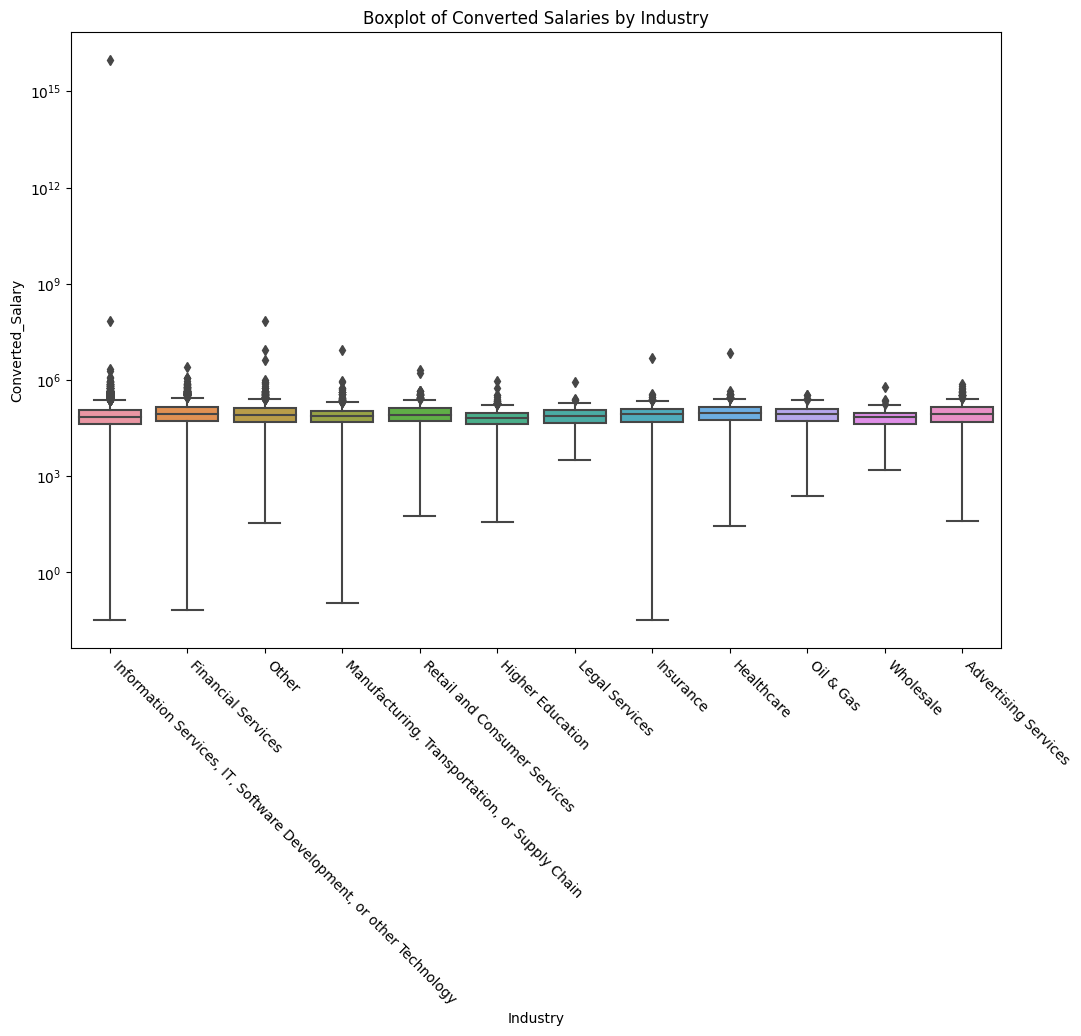

In [7]:
# As the highest entries within the "Information Services, IT, Software Development, or other Technology" field are exorbitantly high and don't accurately represent the field as a whole, I instead show the top 1% and median of compensation per industry field in EUR. This way the result is more resistant to outliers

plt.figure(figsize=(12, 8))
plt.title('Boxplot of Converted Salaries by Industry')
sns.boxplot(x='Industry', y='Converted_Salary', data=converted_currency)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xticks(rotation=-45, ha='left')
plt.show()

### Figure 1: Boxplot of Converted Salaries by Industry Field

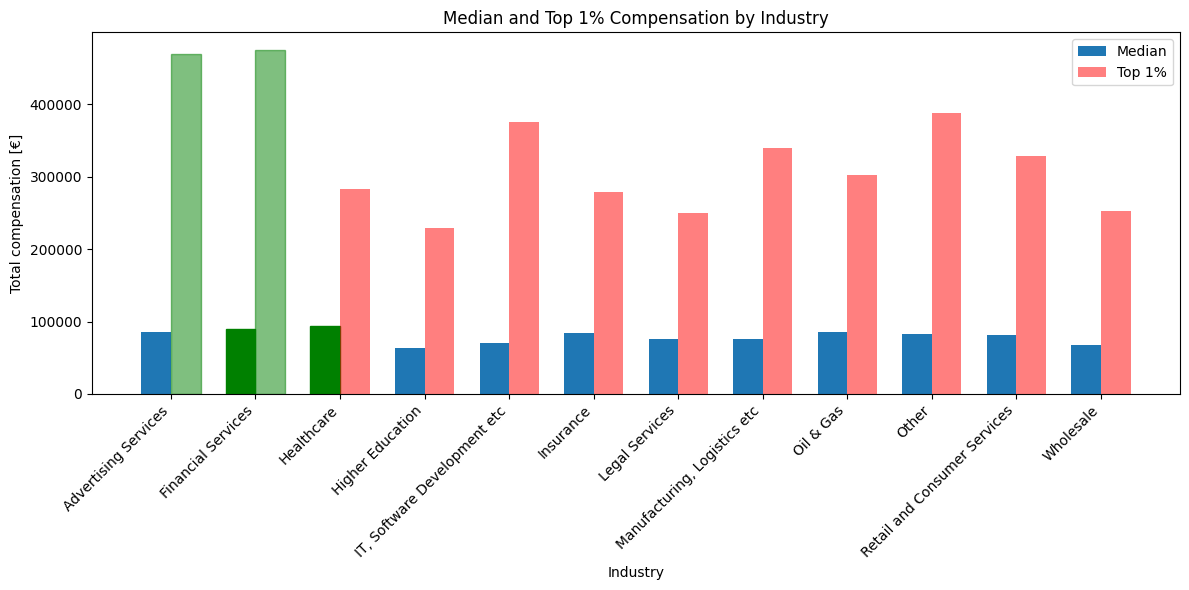

In [8]:
# Group by 'Industry' and calculate the top 1% 'Converted_Salary'
max_comp_totals = converted_currency.groupby('Industry')['Converted_Salary'].quantile(0.99).reset_index()

# Group by 'Industry' and calculate the median 'Converted_Salary'
median_comp_totals = converted_currency.groupby('Industry')['Converted_Salary'].median().reset_index()

# Create a mapping of abbreviations for long industry names
abbreviations = {
    'Information Services, IT, Software Development, or other Technology': 'IT, Software Development etc',
    'Manufacturing, Transportation, or Supply Chain': 'Manufacturing, Logistics etc'
}

# Replace long industry names with abbreviations
max_comp_totals['Industry'] = max_comp_totals['Industry'].replace(abbreviations)
median_comp_totals['Industry'] = median_comp_totals['Industry'].replace(abbreviations)

# Set the figure size 
plt.figure(figsize=(12, 6))

# Calculate the number of industries
num_industries = len(max_comp_totals['Industry'])

# Define the width of each bar
bar_width = 0.35

# Define the x-axis positions for the bars
index = np.arange(num_industries)

# Create the grouped bar plots for median and top 1% values
plt.bar(index, median_comp_totals['Converted_Salary'], bar_width, label='Median')
plt.bar(index + bar_width, max_comp_totals['Converted_Salary'], bar_width, color='red', alpha=0.5, label='Top 1%')

# Set the x-axis labels, ticks, and rotation
plt.xlabel('Industry')
plt.ylabel('Total compensation [€]')
plt.title('Median and Top 1% Compensation by Industry')
plt.xticks(index + bar_width / 2, max_comp_totals['Industry'], rotation=45, ha='right')

# Add a legend
plt.legend()

# Define a threshold for the top 10%
threshold_max = max_comp_totals['Converted_Salary'].quantile(0.90)
threshold_median = median_comp_totals['Converted_Salary'].quantile(0.90)

# Apply conditional coloring to bars based on the threshold for both datasets
for i in range(num_industries):
    if max_comp_totals['Converted_Salary'][i] >= threshold_max:
        plt.gca().get_children()[i + num_industries].set_color('green')  # Set color for top 1% bars
    if median_comp_totals['Converted_Salary'][i] >= threshold_median:
        plt.gca().get_children()[i].set_color('green')  # Set color for median bars

# Show the plot
plt.tight_layout()
plt.show()


### Figure 2: Median and Top 1% Compensation by Industry Field

In 2023 the most profitable industry field as a developer was Financial Services with the median and peak compensation being the highest among the listed fields.  
Closely followed Advertising Services with a comparably high top end compensation of 470k.  
Median compensation showed less drastic differences, with Financial Services and Healthcare being in the top 10% of industry field.  

### It looks like the sector most closely connected to financial flows, also reaps the most fiscal gains in 2023.


<img src="images/green-divider.png" style="width: 100%;" />


### Which type of Developer gets the highest compensation in 2023? 

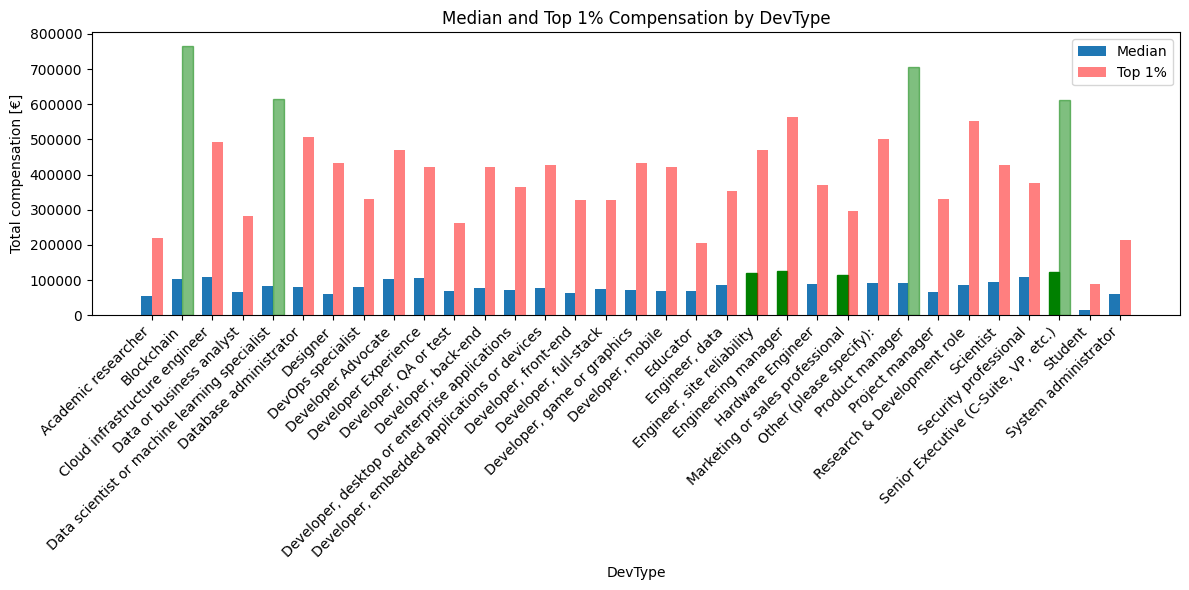

In [9]:
# Group by 'DevType' and calculate the maximum 'Converted_Salary'
max_comp_totals = converted_currency.groupby('DevType')['Converted_Salary'].quantile(0.99).reset_index()

# Group by 'Industry' and calculate the median 'Converted_Salary'
median_comp_totals = converted_currency.groupby('DevType')['Converted_Salary'].median().reset_index()

# Create a mapping of abbreviations for long industry names
abbreviations = {
    'Information Services, IT, Software Development, or other Technology': 'IT, Software Development etc',
    'Manufacturing, Transportation, or Supply Chain': 'Manufacturing, Logistics etc'
}

# Replace long industry names with abbreviations
max_comp_totals['DevType'] = max_comp_totals['DevType'].replace(abbreviations)
median_comp_totals['DevType'] = median_comp_totals['DevType'].replace(abbreviations)

# Set the figure size 
plt.figure(figsize=(12, 6))

# Calculate the number of Developer types
num_devs = len(max_comp_totals['DevType'])

# Define the width of each bar
bar_width = 0.35

# Define the x-axis positions for the bars
index = np.arange(num_devs)

# Create the grouped bar plots for median and top 1% values
plt.bar(index, median_comp_totals['Converted_Salary'], bar_width, label='Median')
plt.bar(index + bar_width, max_comp_totals['Converted_Salary'], bar_width, color='red', alpha=0.5, label='Top 1%')

# Set the x-axis labels, ticks, and rotation
plt.xlabel('DevType')
plt.ylabel('Total compensation [€]')
plt.title('Median and Top 1% Compensation by DevType')
plt.xticks(index + bar_width / 2, max_comp_totals['DevType'], rotation=45, ha='right')

# Add a legend
plt.legend()

# Define a threshold for the top 10%
threshold_max = max_comp_totals['Converted_Salary'].quantile(0.90)
threshold_median = median_comp_totals['Converted_Salary'].quantile(0.90)

# Apply conditional coloring to bars based on the threshold for both datasets
for i in range(num_devs):
    if max_comp_totals['Converted_Salary'][i] >= threshold_max:
        plt.gca().get_children()[i + num_devs].set_color('green')  # Set color for top 1% bars
    if median_comp_totals['Converted_Salary'][i] >= threshold_median:
        plt.gca().get_children()[i].set_color('green')  # Set color for median bars

# Show the plot
plt.tight_layout()
plt.show()


### Figure 3: Median and Top 1% Compensation by Developer Type 


<img src="images/green-divider.png" style="width: 100%;" />


## How much does remote working matter to employees?  

The covid pandemic forced a lot of companies into remote working to prevent infection of the work force and due to lockdown. Since the passing of the pandemic, life has gone more or less back to normal, but it has also shown that not all work activities have to be performed at the office. This begs the question:  

### Whats the distribution of remote work and education level?

Since the preference for remote, hybrid or in-person is not necessarily part of the survey, we have to take a roundabout way to answer this question.

### Working Preference by Education Level

In [10]:
# Define a custom function to calculate relative preferences within each group
def calculate_relative_preferences(group, column_name):
    total = group[column_name].count()  # Total count of preferences in the group
    relative_preferences = group['RemoteWork'].value_counts() / total  # Calculate relative preferences
    return relative_preferences

def plot_work_preference_by_education(df, ax):
    # Create a mapping of abbreviations for long EdLevel names
    abbreviations = {
        'Associate degree (A.A., A.S., etc.)': 'Associate degree',
        "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "Bachelor’s degree",
        "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "Master’s degree",
        "Primary/elementary school": "Primary/elementary school",
        "Professional degree (JD, MD, Ph.D, Ed.D, etc.)": "Professional degree",
        "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "Secondary school",
        "Some college/university study without earning a degree": "college w/o degree",
        "Something else": "Something else"
    }

    # Map the 'EdLevel' column to the abbreviated names
    df['Abbreviated_EdLevel'] = df['EdLevel'].map(abbreviations)

    # Group the data by 'EdLevel' and apply the custom function to calculate relative preferences
    grouped_data = df.groupby('Abbreviated_EdLevel').apply(calculate_relative_preferences, column_name='EdLevel').unstack(fill_value=0)

    # Normalize each row so that the total height is 1.0
    normalized_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)

    # Sort the DataFrame by the percentage of "Remote" in descending order
    sorted_data = normalized_data.sort_values(by='Remote', ascending=False)

    # Create a stacked bar chart with the sorted data
    sorted_data.plot(kind='bar', stacked=True, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('Relative Preference')
    ax.set_title('Work Preference by Education Level', fontsize='large')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

# # Create a single figure and axis outside the function
# fig, ax = plt.subplots(figsize=(10, 6))

# # Call the function with the provided axis
# plot_work_preference_by_education(df, ax)

# # Place the legend outside the bar area
# ax.legend(title='Preference', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Show the plot
# plt.show()

### Working Preference by Industry Field

In [11]:
def plot_work_preference_by_industry(df, ax):
    # Group the data by 'Industry' and apply the custom function to calculate relative preferences
    grouped_data = df.groupby('Industry').apply(calculate_relative_preferences, column_name = "Industry").unstack(fill_value=0)

    # Normalize each row so that the total height is 1.0
    normalized_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)

    # Sort the DataFrame by the percentage of "Remote" in descending order
    sorted_data = normalized_data.sort_values(by='Remote', ascending=False)

    # Create a stacked bar chart with the sorted data
    sorted_data.plot(kind='bar', stacked=True, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('Relative Preference')
    ax.set_title('Work Preference by Industry Field', fontsize='large')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
    
# # Create a single figure and axis outside the function
# fig, ax = plt.subplots(figsize=(10, 6))

# # Call the function with the provided axis
# plot_work_preference_by_industry(df, ax)

# # Place the legend outside the bar area
# ax.legend(title='Preference', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Show the plot
# plt.show()

### Working Preference by Developer Type

In [12]:
def plot_work_preference_by_devtype(df, ax):
    # Group the data by 'DevType' and apply the custom function to calculate relative preferences
    grouped_data = df.groupby('DevType').apply(calculate_relative_preferences, column_name = "DevType").unstack(fill_value=0)

    # Calculate the percentage of people choosing 'Remote'
    percentage_remote = grouped_data['Remote'].mul(100)

    # Sort the dataframe based on the percentage of people choosing 'Remote'
    sorted_index = percentage_remote.sort_values(ascending=False).index
    grouped_data_sorted = grouped_data.reindex(sorted_index)

    # Normalize each row so that the total height is 1.0
    normalized_data = grouped_data_sorted.div(grouped_data_sorted.sum(axis=1), axis=0)

    # Create a stacked bar chart
    normalized_data.plot(kind='bar', stacked=True, ax =ax)
    ax.set_xlabel('')
    ax.set_ylabel('Relative Preference')
    ax.set_title('Work Preference by Developer Type', fontsize='large')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

# # Create a single figure and axis outside the function
# fig, ax = plt.subplots(figsize=(20, 6))

# # Call the function with the provided axis
# plot_work_preference_by_devtype(df, ax)

# # Place the legend outside the bar area
# ax.legend(title='Preference', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Show the plot
# plt.show()

### Working Preference by Age

In [24]:
def plot_work_preference_by_age(df, ax):
    # Group the data by 'Age' and apply the custom function to calculate relative preferences
    grouped_data = df.groupby('Age').apply(calculate_relative_preferences, column_name = "Age").unstack(fill_value=0)

    # Calculate the percentage of people choosing 'Remote'
    percentage_remote = grouped_data['Remote'].mul(100)

    # Sort the dataframe based on the percentage of people choosing 'Remote'
    sorted_index = percentage_remote.sort_values(ascending=False).index
    grouped_data_sorted = grouped_data.reindex(sorted_index)

    # Normalize each row so that the total height is 1.0
    normalized_data = grouped_data_sorted.div(grouped_data_sorted.sum(axis=1), axis=0)

    # Create a stacked bar chart
    normalized_data.plot(kind='bar', stacked=True, ax = ax)
    ax.set_xlabel('')
    ax.set_ylabel('Relative Preference')
    ax.set_title('Work Preference by Age', fontsize='large')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

# # Create a single figure and axis outside the function
# fig, ax = plt.subplots(figsize=(10, 6))

# # Call the function with the provided axis
# plot_work_preference_by_age(df, ax)

# # Place the legend outside the bar area
# ax.legend(title='Preference', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Show the plot
# plt.show()

### Working Preference by Organization Size

In [14]:
def plot_work_preference_by_orgsize(df, ax):
    # Group the data by 'DevType' and apply the custom function to calculate relative preferences
    grouped_data = df.groupby('OrgSize').apply(calculate_relative_preferences, column_name = "OrgSize").unstack(fill_value=0)

    # Calculate the percentage of people choosing 'Remote'
    percentage_remote = grouped_data['Remote'].mul(100)

    # Sort the dataframe based on the percentage of people choosing 'Remote'
    sorted_index = percentage_remote.sort_values(ascending=False).index
    grouped_data_sorted = grouped_data.reindex(sorted_index)

    # Normalize each row so that the total height is 1.0
    normalized_data = grouped_data_sorted.div(grouped_data_sorted.sum(axis=1), axis=0)

    # Create a stacked bar chart
    normalized_data.plot(kind='bar', stacked=True, ax =ax)
    ax.set_xlabel('')
    ax.set_ylabel('Relative Preference')
    ax.set_title('Work Preference by Organization Size', fontsize='large')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


# Create a single figure and axis outside the function
# fig, ax = plt.subplots(figsize=(10, 6))

# # Call the function with the provided axis
# plot_work_preference_by_orgsize(df, ax)

# # Place the legend outside the bar area
# ax.legend(title='Preference', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Show the plot
# plt.show()

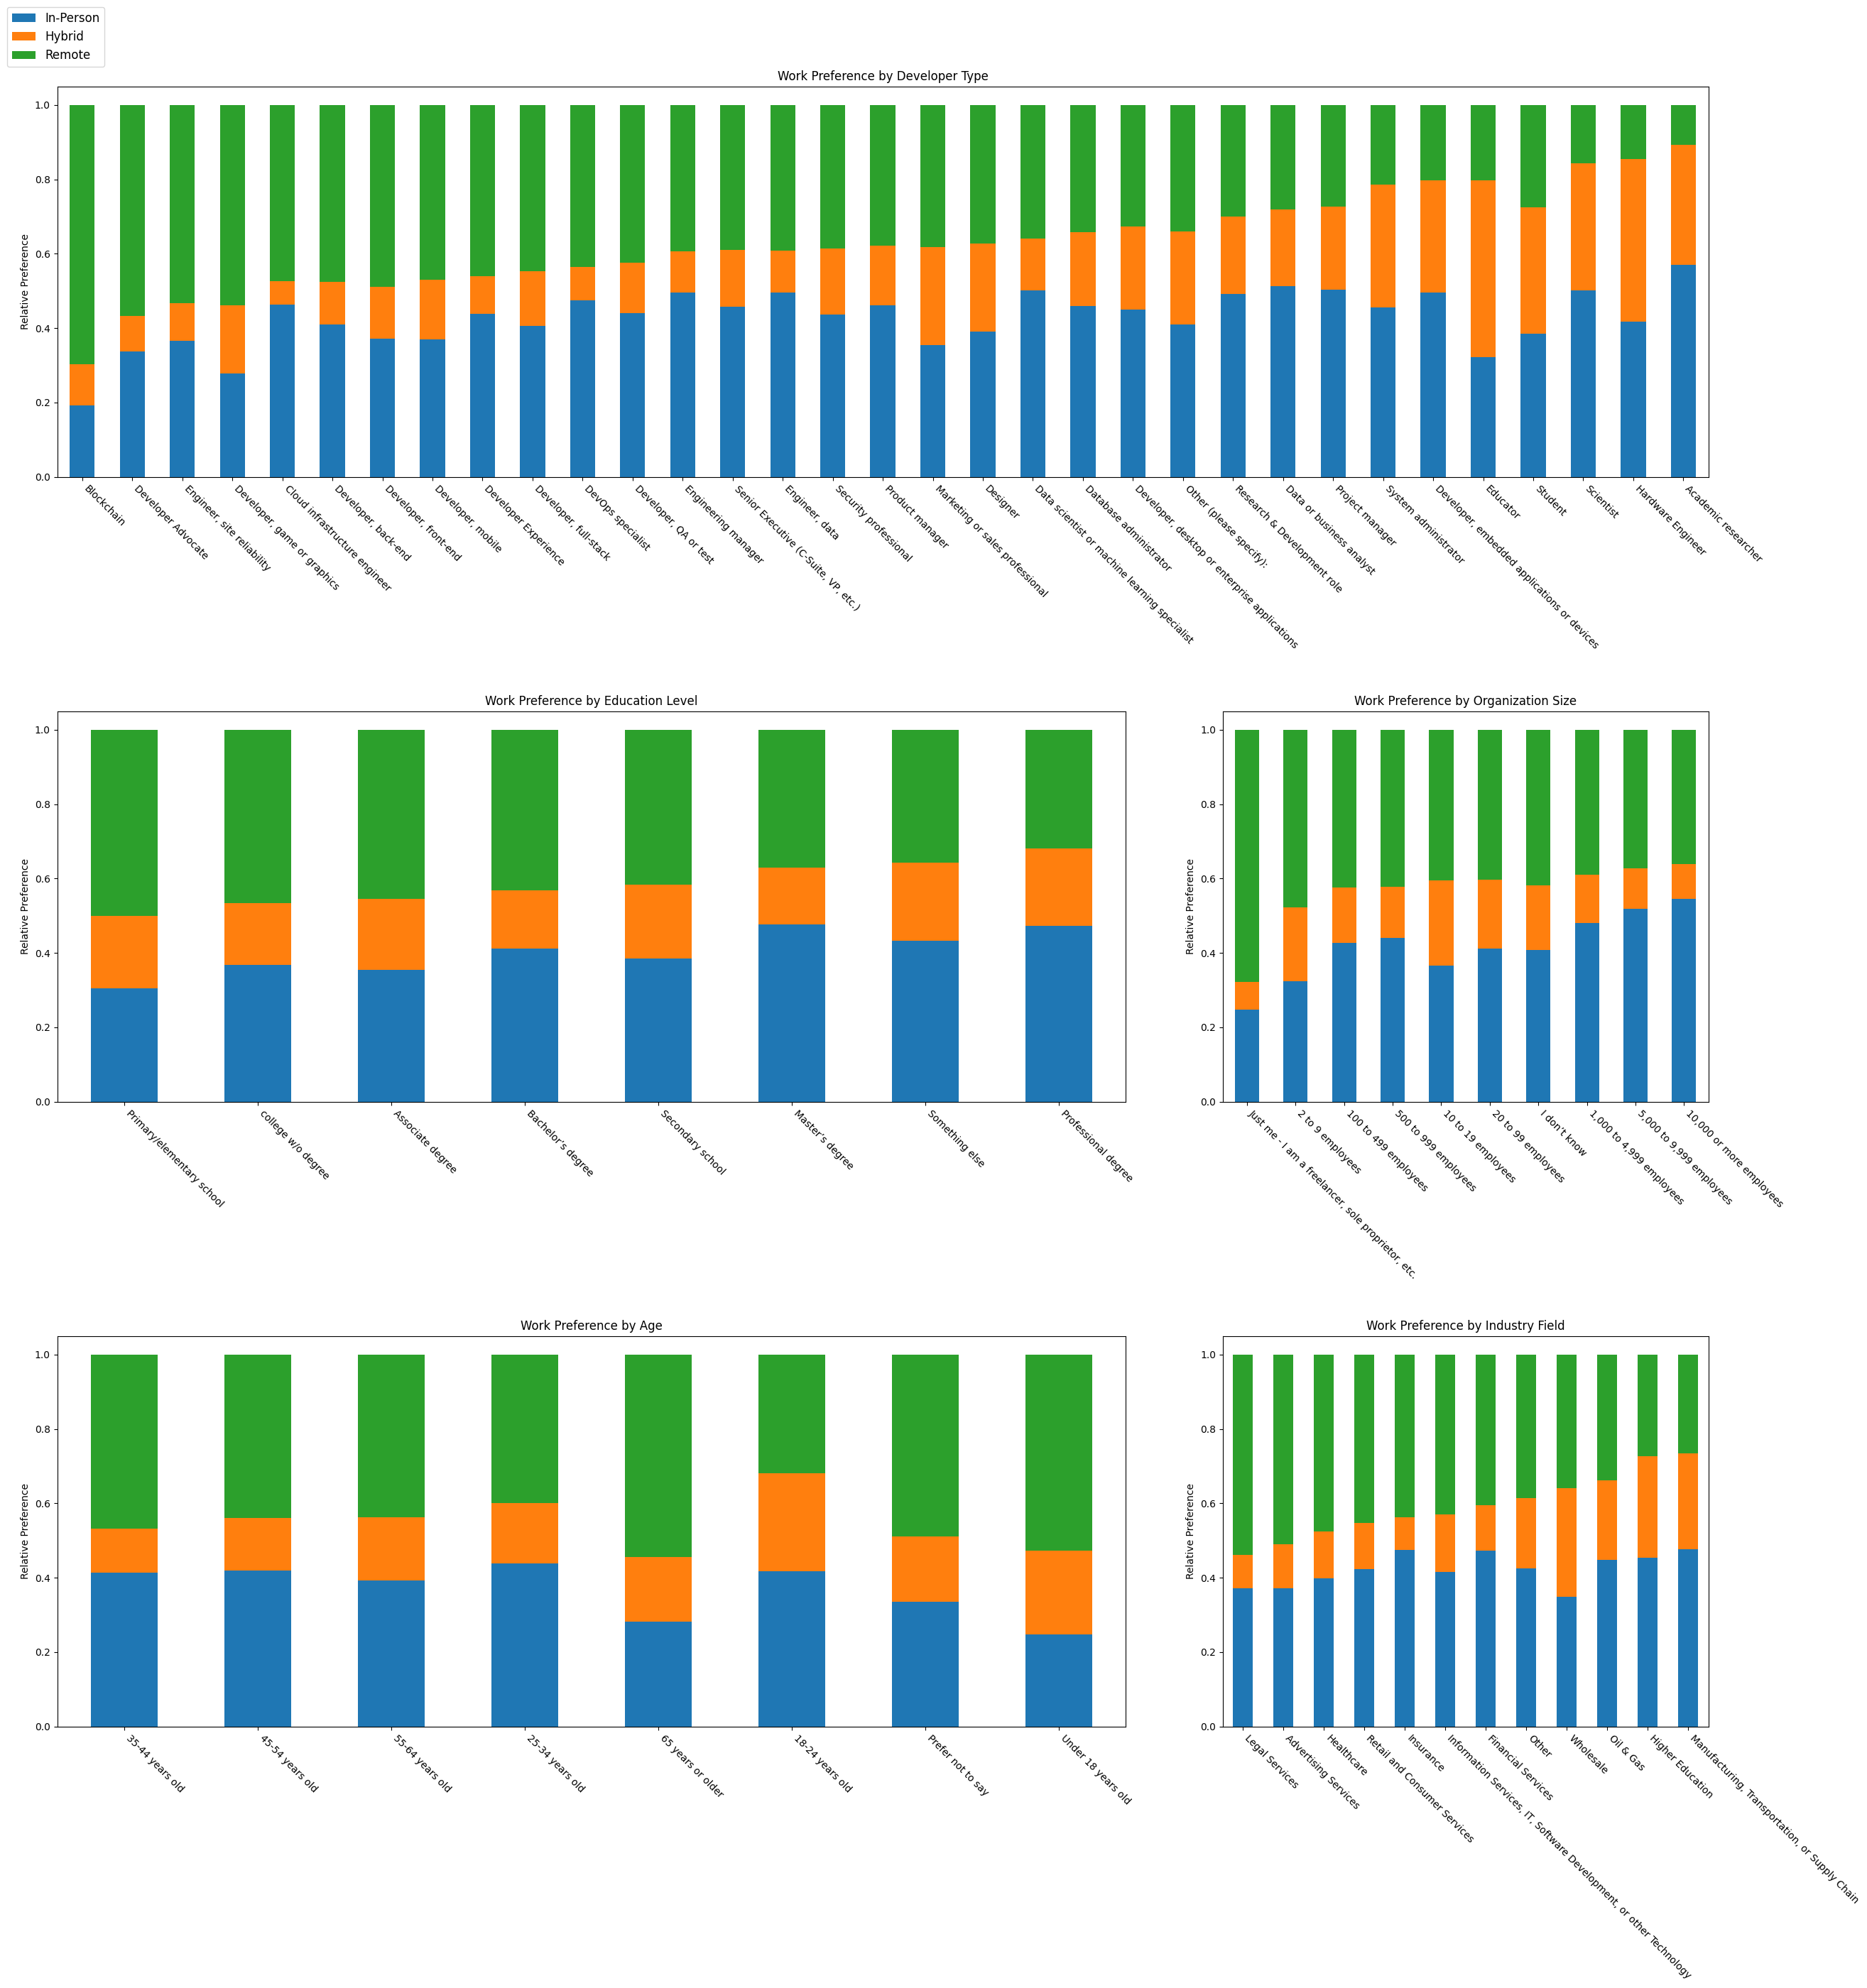

In [15]:
fig3 = plt.figure(figsize=(30, 30))
gs = fig3.add_gridspec(3, 3, hspace=0.6)

f3_ax1 = fig3.add_subplot(gs[0, :])

f3_ax2 = fig3.add_subplot(gs[1, :2])

f3_ax3 = fig3.add_subplot(gs[1, 2])

f3_ax4 = fig3.add_subplot(gs[2, :2])

f3_ax5 = fig3.add_subplot(gs[2, 2])

# Plotting functions
plot_work_preference_by_devtype(df, f3_ax1)
plot_work_preference_by_industry(df, f3_ax5)
plot_work_preference_by_orgsize(df, f3_ax3)
plot_work_preference_by_age(df, f3_ax4)
plot_work_preference_by_education(df, f3_ax2)

# Disable legend for each subplot
f3_ax1.legend().set_visible(False)
f3_ax2.legend().set_visible(False)
f3_ax3.legend().set_visible(False)
f3_ax4.legend().set_visible(False)
f3_ax5.legend().set_visible(False)

# Create a common legend outside the subplots
legend_labels = ["In-Person", "Hybrid", "Remote"]  # Replace with your actual legend labels

# Adjust bbox_to_anchor to control the position of the legend more precisely
fig3.legend(labels=legend_labels, loc='upper right', bbox_to_anchor=(0.15, 0.92), fontsize='large')

plt.show()


### Figure 4: Work Preference by Developer Type, Education Level, Organization Size, Age & Industry Field

The figure above shows some of the metrics I thought might influence the proportion of people working remotely.  
As the preference per-se is not mentioned in the survey, we can still make assumptions about peoples desire and possibility to work remotely.  
The data above paints a picture in which people of newer Development branches, namely Blockchain, Cloud Infrastructure development and Developer Advocate work more remotely than established professions that are not unique to coding.  
By this I mean the fields of teaching, education, hardware engineering and science, which have the among the lowest scores of remote work in the survey. This probably points towards a necessity of interacting with people or objects that can not be replaced by remote work.  
Among educational Levels, the higher the education, the less people work remotely, this is probably a conjunction between the level of education and the type of developer these people represent. As jobs in hardware engineering science and education rely on a certain academic degree, these data go hand in hand.  
Its interesting to see that in smaller sized companies more people work remotely than in larger companies. On the lowest end, being a freelancer often doesn't come with the "luxury" of having an office space, which makes sense. On the other hand larger companies may be more reliant on people working in person to "ensure" a prosperous working environment by having employees coming into office.  
Among the Age group people under the age of 18 and people over the age of 65 show a high frequency of remote work, probably due to independent or part-time employment, as these age groups are outside the common working age. Within the ages of 18 and 65 there is not a clear trend of remote or in-person work.  
Among the different fields of Industry Legal Serives, Advertising and Healthcare show the highest frequency of remote work, maybe due to the contractory nature of these professions and a higher abundance of freelance work in these fields. Professions in fields of Manufacturing, Transportation, Supply Chain, Higher Education and comparable jobs that rely on hands on contact with wares or people show the lowest frequency of remote work. 


The survey allows for multiple entries in the Employment field. For better visualization I count the individual categories listed and create plots how the relate to work preferences.

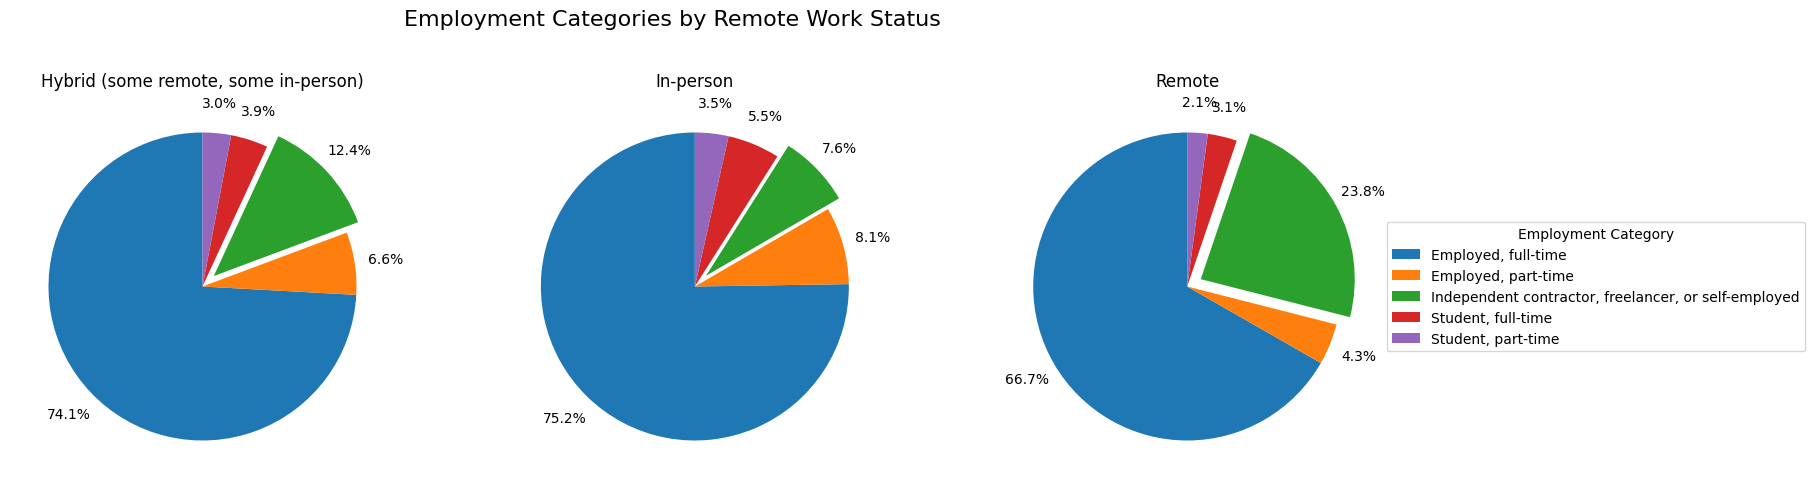

In [16]:
# Create binary columns for each category
categories = ['Employed, full-time', 
              'Employed, part-time', 
              'Independent contractor, freelancer, or self-employed',
              'Student, full-time',
              'Student, part-time']

for category in categories:
    df[category] = df['Employment'].str.contains(category, case=False, na=False).astype(int)

# Group by 'RemoteWork' and sum the counts for each category
grouped_data = df.groupby('RemoteWork')[categories].sum().reset_index()

# Plot the data as pie charts
fig, axes = plt.subplots(nrows=1, ncols=len(grouped_data), figsize=(18, 5), subplot_kw=dict(aspect="equal"))

explode = (0, 0, 0.1, 0, 0)


# Iterate through each 'RemoteWork' category and create a pie chart
for i, (remote_work_status, data) in enumerate(grouped_data.groupby('RemoteWork')):
    ax = axes[i]
    labels = data[categories].columns
    sizes = data[categories].iloc[0]
    wedges, texts, autotexts = ax.pie(
        sizes, autopct='%1.1f%%', startangle=90,
        pctdistance=1.2, textprops=dict(color="black"),
        explode=explode
    )

    # Set title
    ax.set_title(remote_work_status)

# Create legend
ax.legend(wedges, labels, title="Employment Category", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.suptitle('Employment Categories by Remote Work Status', y=1.05, fontsize=16)
plt.show()



<img src="images/green-divider.png" style="width: 100%;" />


### How does coding experience affect the level of pay?

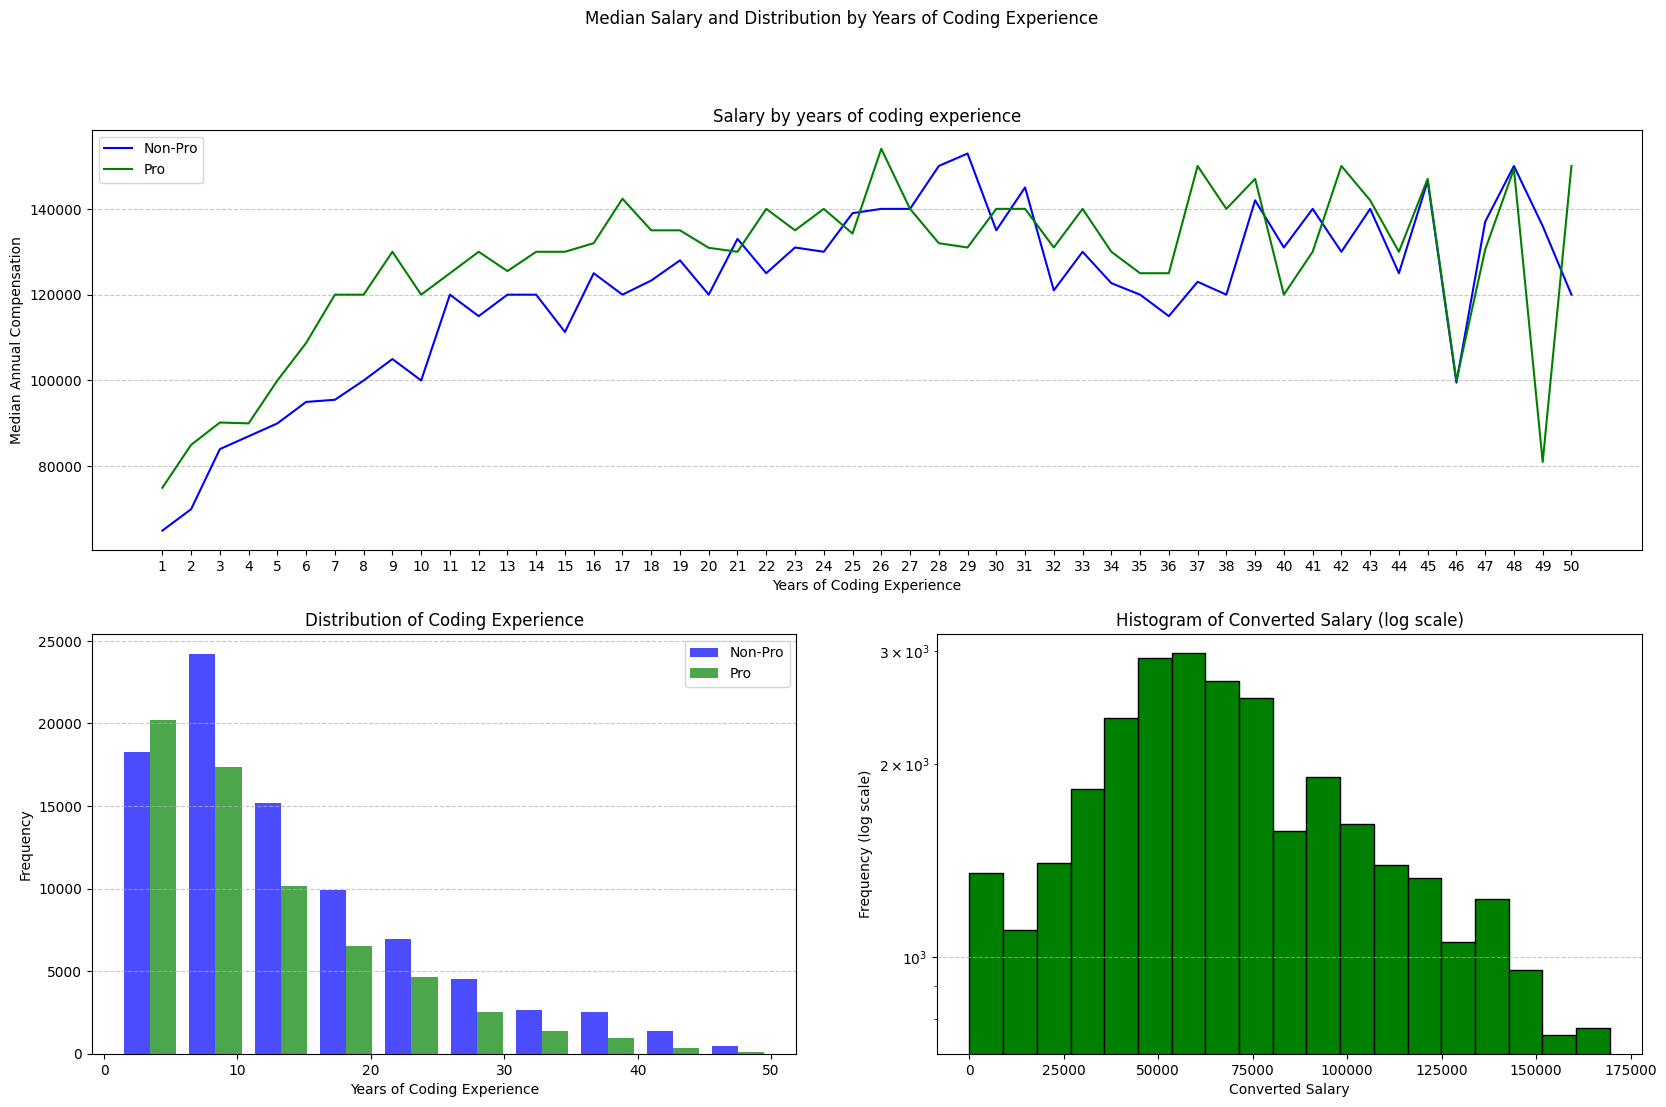

In [17]:
# Assuming df is your DataFrame and 'Converted_Salary' is the column of interest
salary_data = df['Converted_Salary'].dropna()

# Exclude zero values
salary_data = salary_data[(salary_data > salary_data.quantile(.05)) & (~salary_data.isna()) & (salary_data < salary_data.quantile(.95))]

# Convert "YearsCode" and "YearsCodePro" to numeric values
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce')
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')

# Group by "YearsCode" and calculate median compensation
median_compensation = df.groupby('YearsCode')['CompTotal'].median().reset_index()

# Group by "YearsCodePro" and calculate median compensation
median_compensation_pro = df.groupby('YearsCodePro')['CompTotal'].median().reset_index()

# Create a figure with three subplots
fig = plt.figure( figsize=(20, 12))
gs = fig.add_gridspec(2,2)

# Plot the first line on the first subplot
ax1 = fig.add_subplot(gs[0,:])
ax1.plot(median_compensation['YearsCode'], median_compensation['CompTotal'], color='blue', label='Non-Pro')
ax1.plot(median_compensation_pro['YearsCodePro'], median_compensation_pro['CompTotal'], color='green', label='Pro')
ax1.set_title('Salary by years of coding experience')
ax1.set_xlabel('Years of Coding Experience')
ax1.set_ylabel('Median Annual Compensation')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xticks(median_compensation['YearsCode'])
ax1.legend(loc='upper left')


# Plot histograms on the second subplot
ax2 = fig.add_subplot(gs[1,0])
ax2.hist([df['YearsCode'], df['YearsCodePro']], bins=10, color=['blue', 'green'], alpha=0.7, label=['Non-Pro', 'Pro'])
ax2.set_title('Distribution of Coding Experience')
ax2.set_xlabel('Years of Coding Experience')
ax2.set_ylabel('Frequency')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()

# Plot histogram for the distribution of compensations
# Calculate bin width
bin_width = salary_data.max() / 20

# Generate integer bin edges
bin_edges = np.arange(salary_data.min(), salary_data.max(), bin_width).astype(int)

ax3 = fig.add_subplot(gs[1,1])
ax3.hist(salary_data, bins = bin_edges, color='green', edgecolor='black', log=True)  # Use log scale on x-axis
ax3.set_title('Histogram of Converted Salary (log scale)')
ax3.set_xlabel('Converted Salary')
ax3.set_ylabel('Frequency (log scale)')
ax3.grid(axis='y', linestyle='--', alpha=0.7)

# Add a common title for both subplots
plt.suptitle('Median Salary and Distribution by Years of Coding Experience')

plt.show()



<img src="images/green-divider.png" style="width: 100%;" />


### Whats the most popular method to learn coding in 2023?

LearnCode  
LearnCodeOnline	  
LearnCodeCoursesCert  
Language  
Age	  

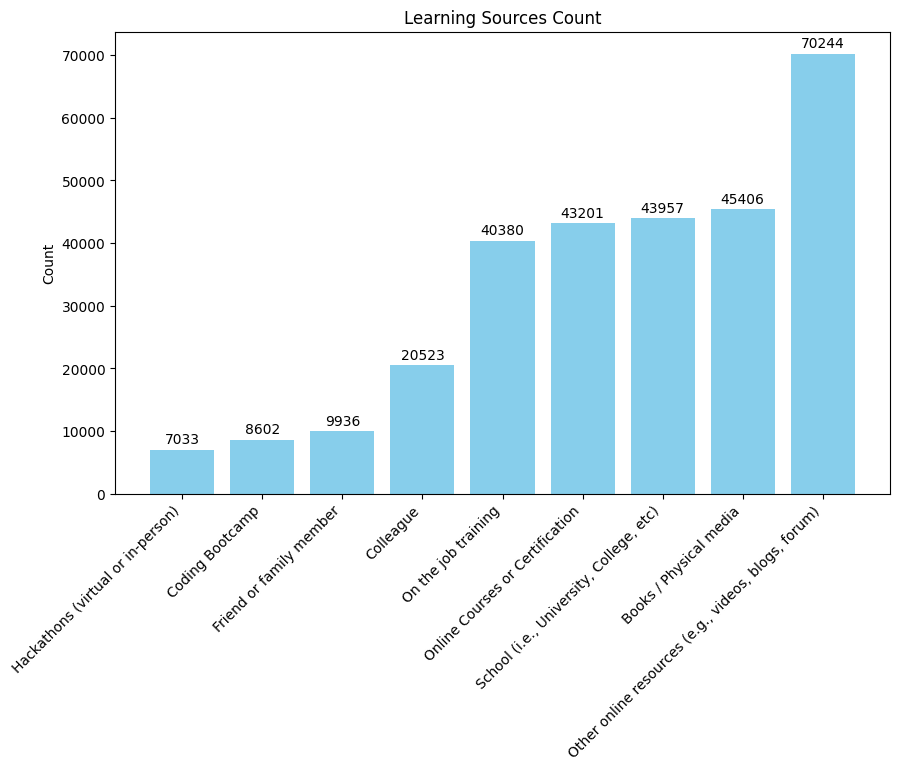

In [18]:
# Create binary columns for each category
categories = ['Books / Physical media', 
              'Coding Bootcamp', 
              'Colleague',
              'Friend or family member',
              'Hackathons (virtual or in-person)',
              'Online Courses or Certification',
              'On the job training',
              'Other online resources (e.g., videos, blogs, forum)',
              'School (i.e., University, College, etc)'
              ]

for category in categories:
    df[category] = df['LearnCode'].str.contains(category, case=False, na=False, regex=False).astype(int)

# Sum the counts for each category
grouped_data = df[categories].sum().reset_index()

# Sort the DataFrame by the count column in ascending order
grouped_data_sorted = grouped_data.sort_values(by=0, ascending=True)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(grouped_data_sorted['index'], grouped_data_sorted[0], color='skyblue')
plt.ylabel('Count')
plt.title('Learning Sources Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Display the count values on top of the bars
for i, count in enumerate(list(grouped_data_sorted[0])):
    plt.text(i, count + 500, str(count), ha='center', va='bottom')

plt.show()

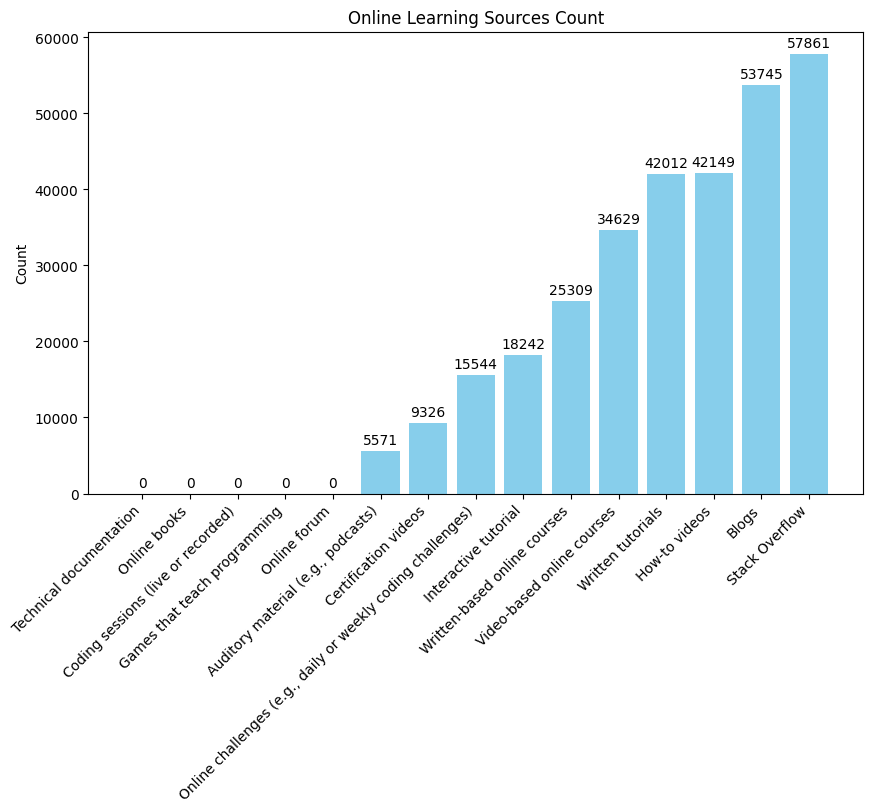

In [19]:
# Create binary columns for each category
categories = ['Technical documentation', 
              'Blogs', 
              'Online books',
              'Coding sessions (live or recorded)',
              'How-to videos',
              'Certification videos',
              'Video-based online courses',
              'Written-based online courses',
              'Auditory material (e.g., podcasts)',
              'Games that teach programming',
              'Online challenges (e.g., daily or weekly coding challenges)',
              'Interactive tutorial',
              'Written tutorials',
              'Online forum',
              'Stack Overflow'
              ]

for category in categories:
    df[category] = df['LearnCodeOnline'].str.contains(category, case=False, na=False, regex=False).astype(int)

# Sum the counts for each category
grouped_data = df[categories].sum().reset_index()

# Sort the DataFrame by the count column in ascending order
grouped_data_sorted = grouped_data.sort_values(by=0, ascending=True)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(grouped_data_sorted['index'], grouped_data_sorted[0], color='skyblue')
plt.ylabel('Count')
plt.title('Online Learning Sources Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Display the count values on top of the bars
for i, count in enumerate(list(grouped_data_sorted[0])):
    plt.text(i, count + 500, str(count), ha='center', va='bottom')

plt.show()

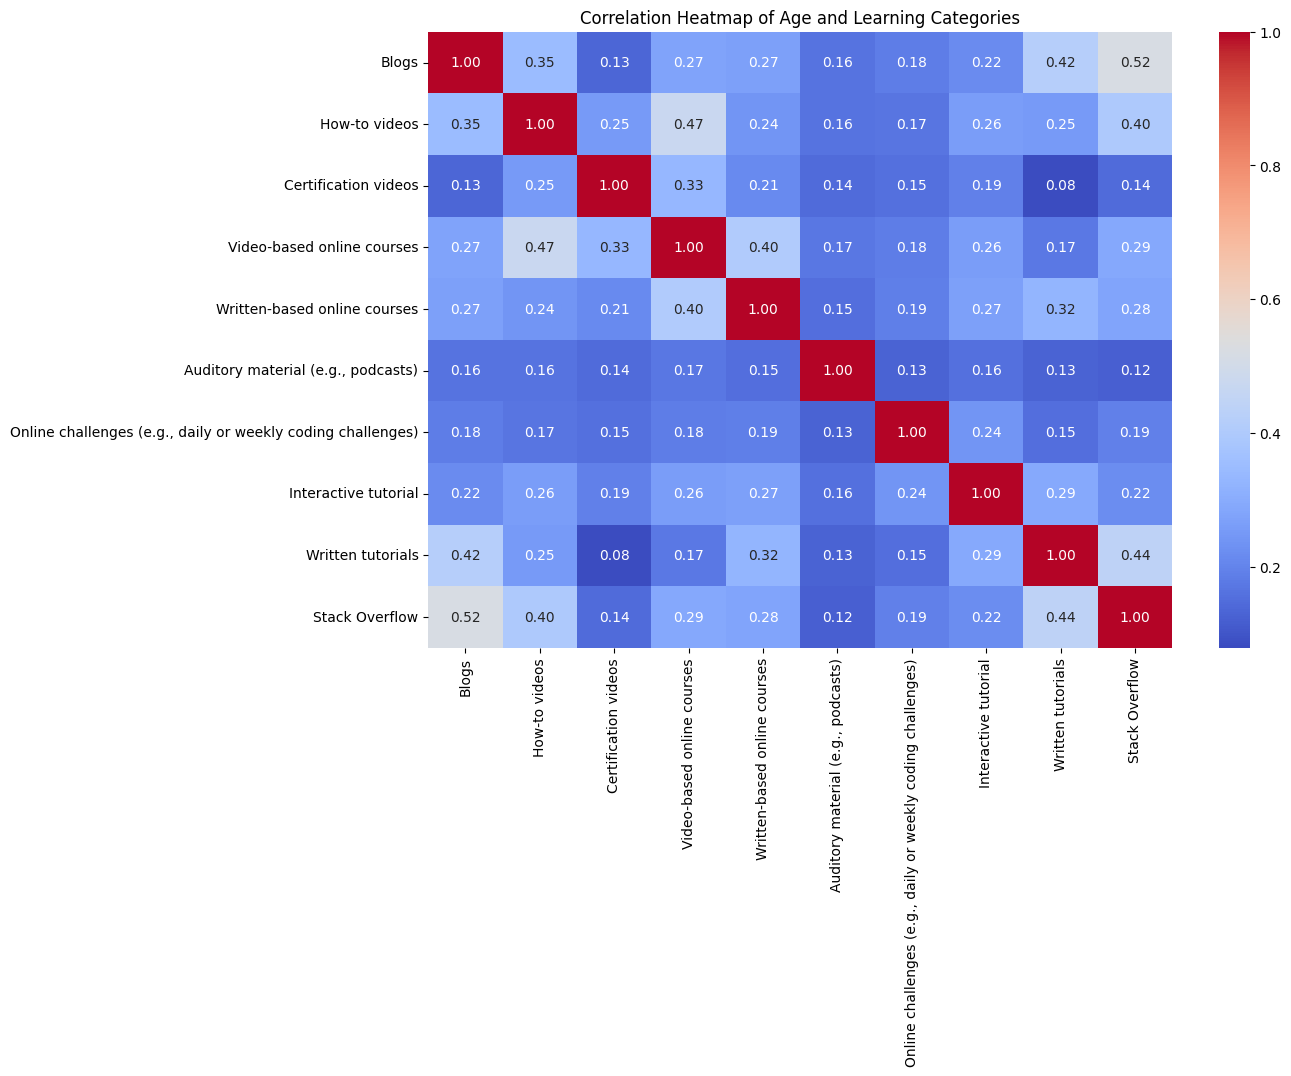

In [20]:
import seaborn as sns

# Create binary columns for each category
categories = [ 
              'Blogs', 
              
              
              'How-to videos',
              'Certification videos',
              'Video-based online courses',
              'Written-based online courses',
              'Auditory material (e.g., podcasts)',
              
              'Online challenges (e.g., daily or weekly coding challenges)',
              'Interactive tutorial',
              'Written tutorials',
              
              'Stack Overflow'
              ]


# Map age categories to numeric values
age_mapping = {
    'Under 18 years old': 9,
    '18-24 years old': 21,
    '25-34 years old': 30,
    '35-44 years old': 40,
    '45-54 years old': 50,
    '55-64 years old': 60,
    '65 years or older': 70,
    'Prefer not to say': None  
}

# Convert the 'Age' column to numeric
df['Age_numeric'] = df['Age'].map(age_mapping)

# Calculate the correlation matrix
correlation_matrix = df[categories].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Age and Learning Categories')
plt.show()



<img src="images/green-divider.png" style="width: 100%;" />


## Are you more likely to get a job as a developer if you have a master's degree?

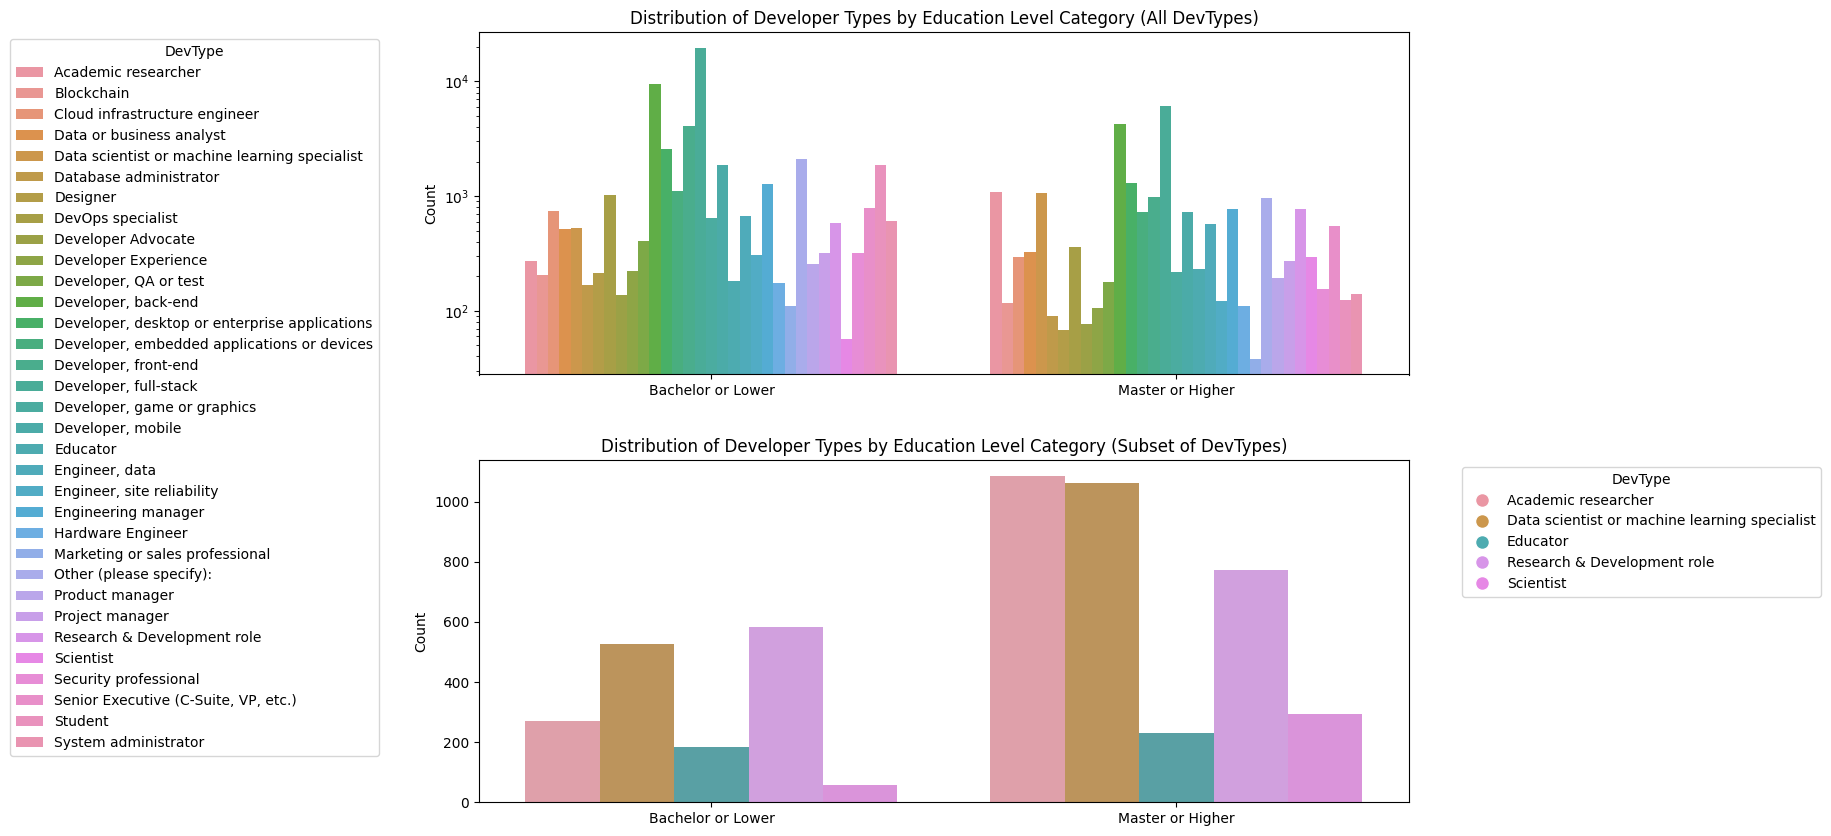

In [21]:
def categorize_education(ed_level):
    if "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)" in ed_level or 'Professional degree (JD, MD, Ph.D, Ed.D, etc.)' in ed_level:
        return 'Master or Higher'
    else:
        return 'Bachelor or Lower'

# Replace NaN values in 'EdLevel' with 'Bachelor or Lower'
df['EdLevel'].fillna('Bachelor or Lower', inplace=True)

# Apply the function to create a new column 'EdLevelCategory'
df['EdLevelCategory'] = df['EdLevel'].apply(categorize_education)

# Group by 'EdLevelCategory' and 'DevType', then count the occurrences for all DevTypes
grouped_data_all = df.groupby(['EdLevelCategory', 'DevType']).size().reset_index(name='Count')

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Subplot 1: Plot all DevTypes using seaborn
sns.barplot(ax=axs[0], x='EdLevelCategory', y='Count', hue='DevType', data=grouped_data_all)
axs[0].set_title('Distribution of Developer Types by Education Level Category (All DevTypes)')
axs[0].set_yscale('log')  # Set y-axis to logarithmic scale
axs[0].set_xlabel("")

# Place the legend outside the bar area
axs[0].legend(title='DevType', bbox_to_anchor=(-0.1, 1), loc='upper right')

# Subplot 2: Plot DevTypes where more people have a Masters Degree
master_counts = grouped_data_all[grouped_data_all['EdLevelCategory'] == 'Master or Higher'].set_index('DevType')['Count']
bachelor_counts = grouped_data_all[grouped_data_all['EdLevelCategory'] == 'Bachelor or Lower'].set_index('DevType')['Count']

selected_devtypes = master_counts[master_counts > bachelor_counts].index.tolist()
selected_data = df[(df['EdLevelCategory'].isin(['Master or Higher', 'Bachelor or Lower'])) & (df['DevType'].isin(selected_devtypes))]
grouped_data_subset = selected_data.groupby(['EdLevelCategory', 'DevType']).size().reset_index(name='Count')

# Get handles and labels from subplot 1 legend
handles, labels = axs[0].get_legend().legend_handles, [t.get_text() for t in axs[0].get_legend().texts]

# Create a dictionary mapping DevTypes to colors
color_palette_all = {label: handle.get_facecolor() for label, handle in zip(labels, handles)}

# Plot using seaborn
sns.barplot(ax=axs[1], x='EdLevelCategory', y='Count', hue='DevType', data=grouped_data_subset)

# Get the handles and labels from subplot 2 legend
handles_subset, labels_subset = axs[1].get_legend().legend_handles, [t.get_text() for t in axs[1].get_legend().texts]

# Create a dictionary mapping DevTypes to colors for subplot 2
color_palette_subset = {label: color_palette_all.get(label, (0.8, 0.8, 0.8, 1.0)) for label in labels_subset}

# Subplot 2: Plot DevTypes where more people have a Masters Degree
ax2 = sns.barplot(ax=axs[1], x='EdLevelCategory', y='Count', hue='DevType', data=grouped_data_subset, palette=color_palette_subset)

# Remove the Seaborn legend
ax2.get_legend().remove()

# Create a custom legend using matplotlib
legend_labels = []
for devtype, color in color_palette_subset.items():
    patch = plt.Line2D([0], [0], marker='o', color='w', label=devtype, markerfacecolor=color, markersize=10)
    legend_labels.append(patch)

# Add the legend to subplot 2
axs[1].legend(handles=legend_labels, title='DevType', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].set_xlabel("")
axs[1].set_title('Distribution of Developer Types by Education Level Category (Subset of DevTypes)')

# Increase space between subplots
fig.subplots_adjust(hspace=0.25)

plt.show()


<img src="images/green-divider.png" style="width: 100%;" />


## Which are the most popular languages of 2023?

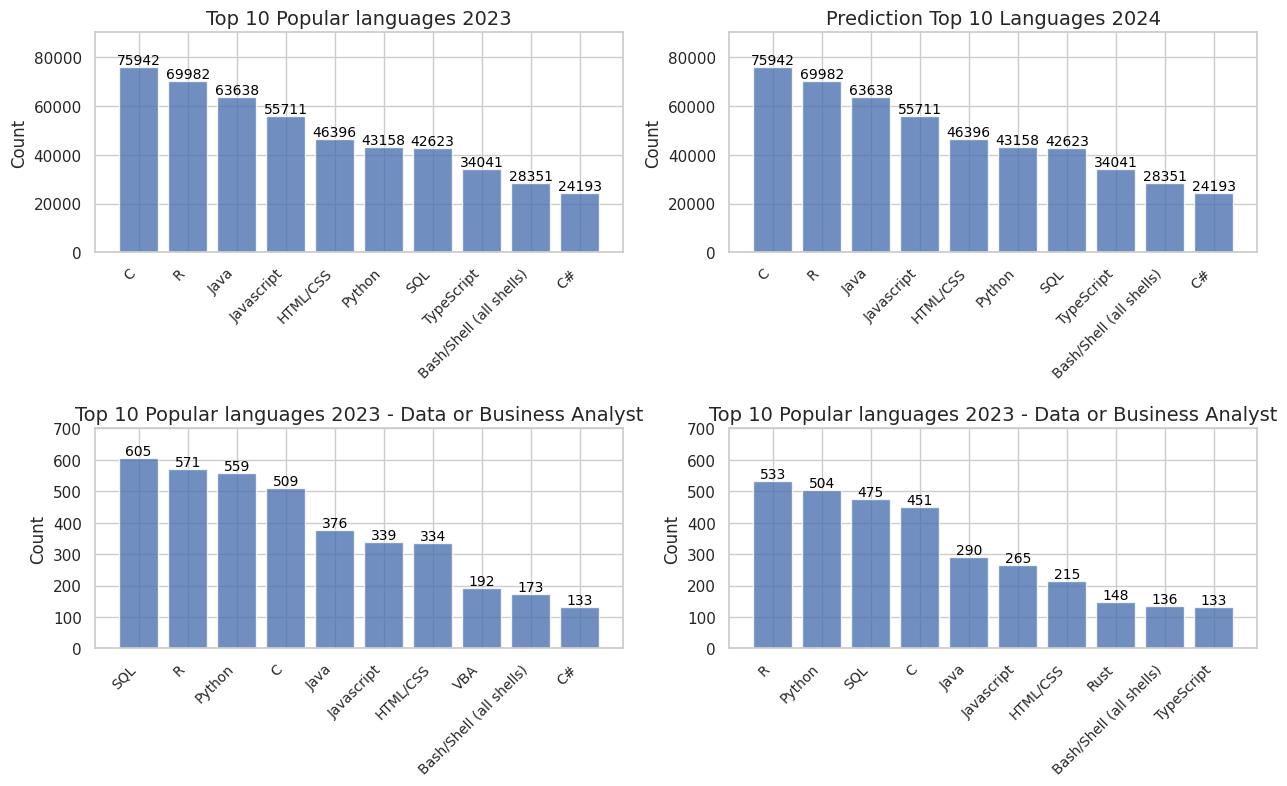

In [22]:
# Set a more visually appealing color palette
sns.set_palette("viridis")

# Function to create binary columns
def create_binary_columns(df, categories, column_name):
    for category in categories:
        df.loc[:, category] = df[column_name].str.contains(category, case=False, na=False, regex=False).astype(int)

# Function to plot bar subplot
def plot_bar_subplot(ax, data, title, ylim=None, value_counts_offset=500):
    ax.bar(data['index'], data[0], alpha=0.8)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(range(len(data['index'])))
    ax.set_xticklabels(data['index'], rotation=45, ha='right', fontsize=10)
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])

    for i, count in enumerate(data[0]):
        offset = value_counts_offset if 'Data or Business Analyst' in title else 0
        ax.text(i, count + offset, str(count), ha='center', va='bottom', fontsize=10, color='black')

# Create binary columns for each category
categories = ["Ada", "Apex", "APL", "Assembly", "Bash/Shell (all shells)", "C", "C#", "C++", "Clojure", "Cobol",
              "Crystal", "Dart", "Delphi", "Elixir", "Erlang", "F#", "Flow", "Fortran", "GDScript", "Go", "Groovy",
              "Haskell", "HTML/CSS", "Java", "Javascript", "Julia", "Kotlin", "Lisp", "Lua", "MATLAB", "Nim",
              "Objective-C", "OCaml", "Perl", "PHP", "PowerShell", "Prolog", "Python", "R", "Raku", "Ruby", "Rust",
              "SAS", "Scala", "Solidity", "SQL", "Swift", "TypeScript", "VBA", "Visual Basic (.Net)", "Zig"]

# Use seaborn to set a visually appealing style
sns.set(style="whitegrid")

# Create binary columns
create_binary_columns(df, categories, 'LanguageHaveWorkedWith')

# Sum the counts for each category
grouped_data = df[categories].sum().reset_index()

# Sort the DataFrame by the count column in ascending order
grouped_data_sorted = grouped_data.sort_values(by=0, ascending=False)[0:10]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 8), gridspec_kw={'hspace': 0.8})

# Plot the first subplot Languages have worked with
plot_bar_subplot(axs[0, 0], grouped_data_sorted, 'Top 10 Popular languages 2023', (0, 90000))

# Plot the second subplot Languages have learned this year
plot_bar_subplot(axs[0, 1], grouped_data_sorted, 'Prediction Top 10 Languages 2024', (0, 90000))

# Prepare third plot Popular languages for Data or Business Analysts
# Filter data for "Data or business analyst"
target_devtype = "Data or business analyst"
filtered_df = df[df['DevType'] == target_devtype]
create_binary_columns(filtered_df, categories, 'LanguageHaveWorkedWith')

# Sum the counts for each category
grouped_data = filtered_df[categories].sum().reset_index()

# Sort the DataFrame by the count column in ascending order
grouped_data_sorted = grouped_data.sort_values(by=0, ascending=False)[0:10]

# Plot
plot_bar_subplot(axs[1, 0], grouped_data_sorted, 'Top 10 Popular languages 2023 - Data or Business Analyst', (0, 700), value_counts_offset=0)

# Prepare fourth plot Popular languages for Data or Business Analysts in 2024
# Filter data for "Data or business analyst"
create_binary_columns(filtered_df, categories, 'LanguageWantToWorkWith')

# Sum the counts for each category
grouped_data = filtered_df[categories].sum().reset_index()

# Sort the DataFrame by the count column in ascending order
grouped_data_sorted = grouped_data.sort_values(by=0, ascending=False)[0:10]

# Plot
plot_bar_subplot(axs[1, 1], grouped_data_sorted, 'Top 10 Popular languages 2023 - Data or Business Analyst', (0, 700), value_counts_offset=0)

plt.show()
